In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import os
from datetime import datetime
from skimage import filters, morphology

print("🚀 Starting Noise Reduction Pipeline")
print("👤 Member: IT24102090 - Bandara D M R M")
print("🔧 Technique: Noise Reduction/Denoising")
print("👥 Group: 2025-Y2-S1-MLB-B8G1-04")
print("="*50)

🚀 Starting Noise Reduction Pipeline
👤 Member: IT24102090 - Bandara D M R M
🔧 Technique: Noise Reduction/Denoising
👥 Group: 2025-Y2-S1-MLB-B8G1-04


In [4]:
def load_unicode_mapping():
    """Load the Unicode mapping file"""
    mapping_file = Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/mappings/unicode_mapping.json")

    if mapping_file.exists():
        with open(mapping_file, 'r', encoding='utf-8') as f:
            mapping = json.load(f)
        print(f"✅ Unicode mapping loaded: {len(mapping['class_to_unicode'])} classes")
        return mapping
    else:
        print("❌ Unicode mapping file not found!")
        return None

unicode_mapping = load_unicode_mapping()

✅ Unicode mapping loaded: 454 classes


In [6]:
def create_folder_structure():
    """Create necessary folders for processing"""

    paths = {
        'input_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/outputs/processed/IT24102031"),
        'output_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/outputs/processed/IT24102090"),
        'eda_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102090"),
        'mapping_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/mappings")
    }

    for name, path in paths.items():
        path.mkdir(parents=True, exist_ok=True)
        print(f"📁 Created: {path}")

    return paths

folder_paths = create_folder_structure()
print("\n✅ Folder structure ready!")

📁 Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/outputs/processed/IT24102031
📁 Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/outputs/processed/IT24102090
📁 Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102090
📁 Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/mappings

✅ Folder structure ready!


In [7]:
def apply_noise_reduction(image_path):
    """Apply multiple noise reduction techniques"""
    try:
        # Read resized image
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            return None, None

        # Convert to float for processing
        image_float = image.astype(np.float32) / 255.0

        # Method 1: Gaussian Blur (removes high-frequency noise)
        gaussian_denoised = cv2.GaussianBlur(image, (3, 3), 0.5)

        # Method 2: Median Filter (removes salt-and-pepper noise)
        median_denoised = cv2.medianBlur(image, 3)

        # Method 3: Bilateral Filter (preserves edges while reducing noise)
        bilateral_denoised = cv2.bilateralFilter(image, 9, 75, 75)

        # Method 4: Non-local Means Denoising
        nlm_denoised = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

        # Method 5: Morphological Operations (remove small artifacts)
        kernel = np.ones((2,2), np.uint8)
        morphological_denoised = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

        # Combined approach: Use bilateral filter as it preserves edges well
        # followed by light morphological closing
        kernel_small = np.ones((1,1), np.uint8)
        final_denoised = cv2.morphologyEx(bilateral_denoised, cv2.MORPH_CLOSE, kernel_small)

        return image, {
            'gaussian': gaussian_denoised,
            'median': median_denoised,
            'bilateral': bilateral_denoised,
            'nlm': nlm_denoised,
            'morphological': morphological_denoised,
            'final': final_denoised
        }

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

In [8]:
def calculate_noise_metrics(original, denoised):
    """Calculate noise reduction metrics"""
    try:
        # Convert to float for calculations
        orig_float = original.astype(np.float32)
        denoised_float = denoised.astype(np.float32)

        # Calculate PSNR (Peak Signal-to-Noise Ratio)
        mse = np.mean((orig_float - denoised_float) ** 2)
        if mse == 0:
            psnr = float('inf')
        else:
            psnr = 20 * np.log10(255.0 / np.sqrt(mse))

        # Calculate noise variance (lower is better after denoising)
        noise_variance_orig = np.var(orig_float)
        noise_variance_denoised = np.var(denoised_float)

        # Edge preservation metric (using Sobel filter)
        edges_orig = cv2.Sobel(original, cv2.CV_64F, 1, 1, ksize=3)
        edges_denoised = cv2.Sobel(denoised, cv2.CV_64F, 1, 1, ksize=3)
        edge_preservation = np.corrcoef(edges_orig.flatten(), edges_denoised.flatten())[0,1]

        return {
            'psnr': psnr,
            'noise_variance_original': noise_variance_orig,
            'noise_variance_denoised': noise_variance_denoised,
            'edge_preservation': edge_preservation
        }
    except:
        return {
            'psnr': 0,
            'noise_variance_original': 0,
            'noise_variance_denoised': 0,
            'edge_preservation': 0
        }

def get_character_info(class_id):
    """Get character info from mapping"""
    if unicode_mapping and str(class_id) in unicode_mapping['class_to_unicode']:
        return unicode_mapping['class_to_unicode'][str(class_id)]
    return {'unicode': f'Class_{class_id}', 'category': 'unknown'}

print("✅ Noise reduction functions ready!")

✅ Noise reduction functions ready!


In [9]:
def process_sample_images(class_id=1, max_samples=5):
    """Process sample images for testing"""

    # Setup paths - taking input from Member D's resized output
    input_path = folder_paths['input_base'] / "resized_80x80_train" / str(class_id)
    output_path = folder_paths['output_base'] / "denoised_train" / str(class_id)
    output_path.mkdir(parents=True, exist_ok=True)

    char_info = get_character_info(class_id)
    print(f"🔤 Processing Class {class_id}: '{char_info['unicode']}' ({char_info['category']})")

    if not input_path.exists():
        print(f"⚠️  Input path not found: {input_path}")
        print("💡 Member D's resized output is required as input!")
        return []

    image_files = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_files.extend(list(input_path.glob(ext)))

    if not image_files:
        print(f"⚠️  No image files found in {input_path}")
        return []

    processed_data = []
    for i, img_file in enumerate(image_files[:max_samples]):
        print(f"🔧 Processing: {img_file.name}")

        original, denoised_results = apply_noise_reduction(img_file)

        if original is not None and denoised_results is not None:
            # Save final denoised image
            output_file = output_path / f"denoised_{img_file.name}"
            cv2.imwrite(str(output_file), denoised_results['final'])

            # Calculate metrics for the final result
            metrics = calculate_noise_metrics(original, denoised_results['final'])

            processed_data.append({
                'original': original,
                'denoised_methods': denoised_results,
                'final_denoised': denoised_results['final'],
                'filename': img_file.name,
                'metrics': metrics
            })

            print(f"   ✅ Saved: {output_file.name} | PSNR: {metrics['psnr']:.2f}")
        else:
            print(f"   ❌ Failed: {img_file.name}")

    print(f"\n🎯 Processed {len(processed_data)} images successfully!")
    return processed_data

sample_data = process_sample_images(class_id=1, max_samples=5)

🔤 Processing Class 1: 'අ' (independent_vowel)
🔧 Processing: resized_norm_hist_eq_gray_39xccd.jpg
   ✅ Saved: denoised_resized_norm_hist_eq_gray_39xccd.jpg | PSNR: 25.42
🔧 Processing: resized_norm_hist_eq_gray_29xccd.jpg
   ✅ Saved: denoised_resized_norm_hist_eq_gray_29xccd.jpg | PSNR: 28.99
🔧 Processing: resized_norm_hist_eq_gray_ad_mlk31.jpg
   ✅ Saved: denoised_resized_norm_hist_eq_gray_ad_mlk31.jpg | PSNR: 33.85
🔧 Processing: resized_norm_hist_eq_gray_ad_mlk30.jpg
   ✅ Saved: denoised_resized_norm_hist_eq_gray_ad_mlk30.jpg | PSNR: 32.72
🔧 Processing: resized_norm_hist_eq_gray_w48.jpg
   ✅ Saved: denoised_resized_norm_hist_eq_gray_w48.jpg | PSNR: 28.73

🎯 Processed 5 images successfully!


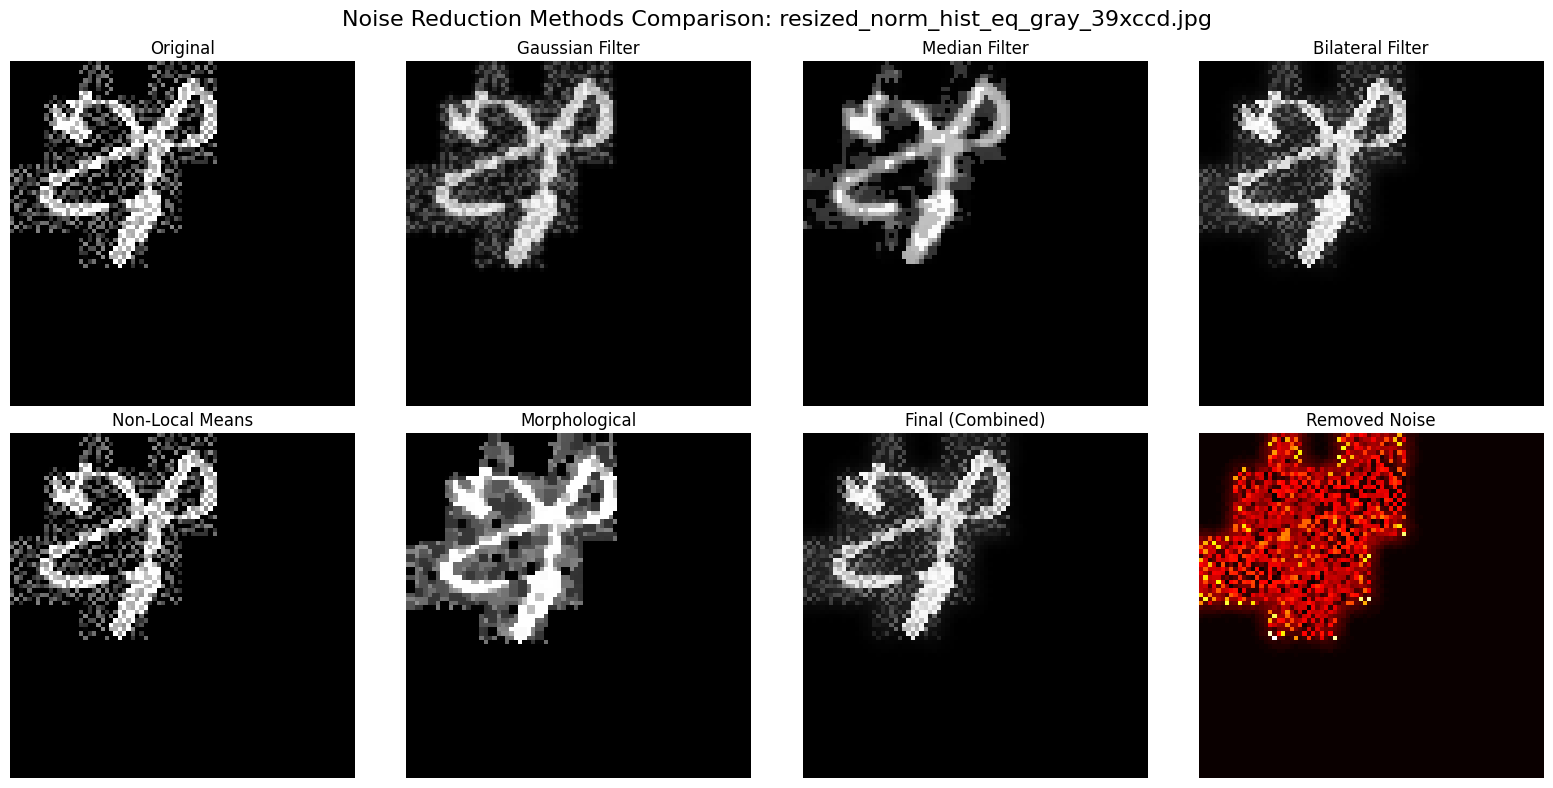

📊 Denoising methods comparison saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102090/denoising_methods_comparison.png


In [10]:
def create_denoising_comparison(sample_data):
    """Create comprehensive denoising comparison"""

    if not sample_data:
        print("⚠️  No sample data available for visualization")
        return

    sample = sample_data[0]  # Use first sample for detailed comparison

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Noise Reduction Methods Comparison: {sample["filename"]}', fontsize=16)

    # Original image
    axes[0, 0].imshow(sample['original'], cmap='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')

    # Gaussian denoising
    axes[0, 1].imshow(sample['denoised_methods']['gaussian'], cmap='gray')
    axes[0, 1].set_title('Gaussian Filter')
    axes[0, 1].axis('off')

    # Median denoising
    axes[0, 2].imshow(sample['denoised_methods']['median'], cmap='gray')
    axes[0, 2].set_title('Median Filter')
    axes[0, 2].axis('off')

    # Bilateral denoising
    axes[0, 3].imshow(sample['denoised_methods']['bilateral'], cmap='gray')
    axes[0, 3].set_title('Bilateral Filter')
    axes[0, 3].axis('off')

    # NLM denoising
    axes[1, 0].imshow(sample['denoised_methods']['nlm'], cmap='gray')
    axes[1, 0].set_title('Non-Local Means')
    axes[1, 0].axis('off')

    # Morphological denoising
    axes[1, 1].imshow(sample['denoised_methods']['morphological'], cmap='gray')
    axes[1, 1].set_title('Morphological')
    axes[1, 1].axis('off')

    # Final result
    axes[1, 2].imshow(sample['denoised_methods']['final'], cmap='gray')
    axes[1, 2].set_title('Final (Combined)')
    axes[1, 2].axis('off')

    # Noise difference
    noise_diff = cv2.absdiff(sample['original'], sample['final_denoised'])
    axes[1, 3].imshow(noise_diff, cmap='hot')
    axes[1, 3].set_title('Removed Noise')
    axes[1, 3].axis('off')

    plt.tight_layout()

    output_file = folder_paths['eda_base'] / 'denoising_methods_comparison.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📊 Denoising methods comparison saved: {output_file}")

create_denoising_comparison(sample_data)

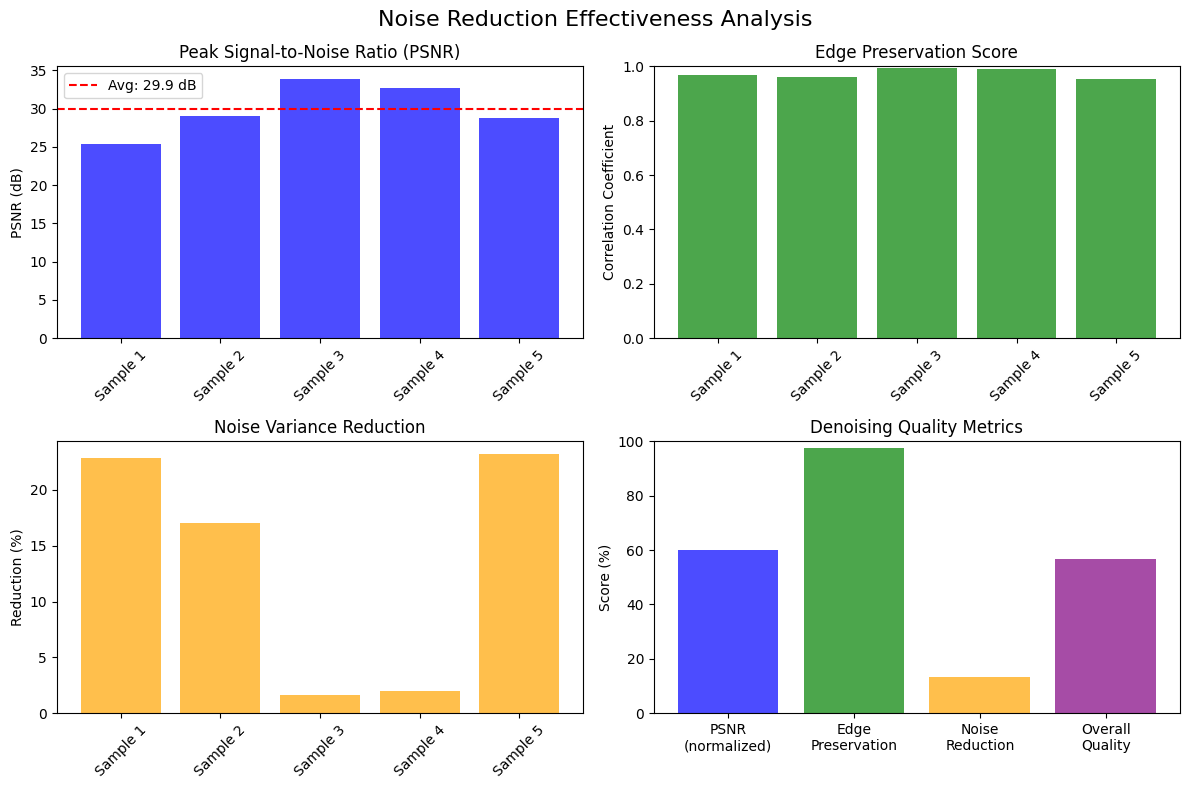

📊 Denoising effectiveness analysis saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102090/denoising_effectiveness.png
📈 Average PSNR: 29.94 dB
📈 Average edge preservation: 0.974
📈 Average noise reduction: 13.4%


In [11]:
def analyze_denoising_effectiveness(sample_data):
    """Analyze denoising effectiveness with metrics"""

    if not sample_data:
        print("⚠️  No data for analysis")
        return {}

    # Extract metrics
    psnr_values = [d['metrics']['psnr'] for d in sample_data]
    edge_preservation = [d['metrics']['edge_preservation'] for d in sample_data]
    noise_reduction = [(d['metrics']['noise_variance_original'] - d['metrics']['noise_variance_denoised'])
                      / d['metrics']['noise_variance_original'] * 100 for d in sample_data]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Noise Reduction Effectiveness Analysis', fontsize=16)

    # Plot 1: PSNR values
    sample_names = [f"Sample {i+1}" for i in range(len(sample_data))]
    axes[0, 0].bar(sample_names, psnr_values, color='blue', alpha=0.7)
    axes[0, 0].set_title('Peak Signal-to-Noise Ratio (PSNR)')
    axes[0, 0].set_ylabel('PSNR (dB)')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Add average line
    avg_psnr = np.mean(psnr_values)
    axes[0, 0].axhline(y=avg_psnr, color='red', linestyle='--', label=f'Avg: {avg_psnr:.1f} dB')
    axes[0, 0].legend()

    # Plot 2: Edge preservation
    axes[0, 1].bar(sample_names, edge_preservation, color='green', alpha=0.7)
    axes[0, 1].set_title('Edge Preservation Score')
    axes[0, 1].set_ylabel('Correlation Coefficient')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].set_ylim(0, 1)

    # Plot 3: Noise reduction percentage
    axes[1, 0].bar(sample_names, noise_reduction, color='orange', alpha=0.7)
    axes[1, 0].set_title('Noise Variance Reduction')
    axes[1, 0].set_ylabel('Reduction (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Plot 4: Overall quality metrics
    metrics = ['PSNR\n(normalized)', 'Edge\nPreservation', 'Noise\nReduction', 'Overall\nQuality']

    # Normalize PSNR to 0-100 scale for comparison
    normalized_psnr = min(100, np.mean(psnr_values) * 2)  # Rough normalization
    avg_edge = np.mean(edge_preservation) * 100
    avg_noise_red = np.mean(noise_reduction)
    overall_quality = (normalized_psnr + avg_edge + avg_noise_red) / 3

    scores = [normalized_psnr, avg_edge, avg_noise_red, overall_quality]
    colors = ['blue', 'green', 'orange', 'purple']

    axes[1, 1].bar(metrics, scores, color=colors, alpha=0.7)
    axes[1, 1].set_title('Denoising Quality Metrics')
    axes[1, 1].set_ylabel('Score (%)')
    axes[1, 1].set_ylim(0, 100)

    plt.tight_layout()

    output_file = folder_paths['eda_base'] / 'denoising_effectiveness.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"📊 Denoising effectiveness analysis saved: {output_file}")
    print(f"📈 Average PSNR: {avg_psnr:.2f} dB")
    print(f"📈 Average edge preservation: {np.mean(edge_preservation):.3f}")
    print(f"📈 Average noise reduction: {np.mean(noise_reduction):.1f}%")

    return {
        'psnr_values': psnr_values,
        'edge_preservation': edge_preservation,
        'noise_reduction': noise_reduction,
        'avg_psnr': avg_psnr
    }

analysis_stats = analyze_denoising_effectiveness(sample_data)

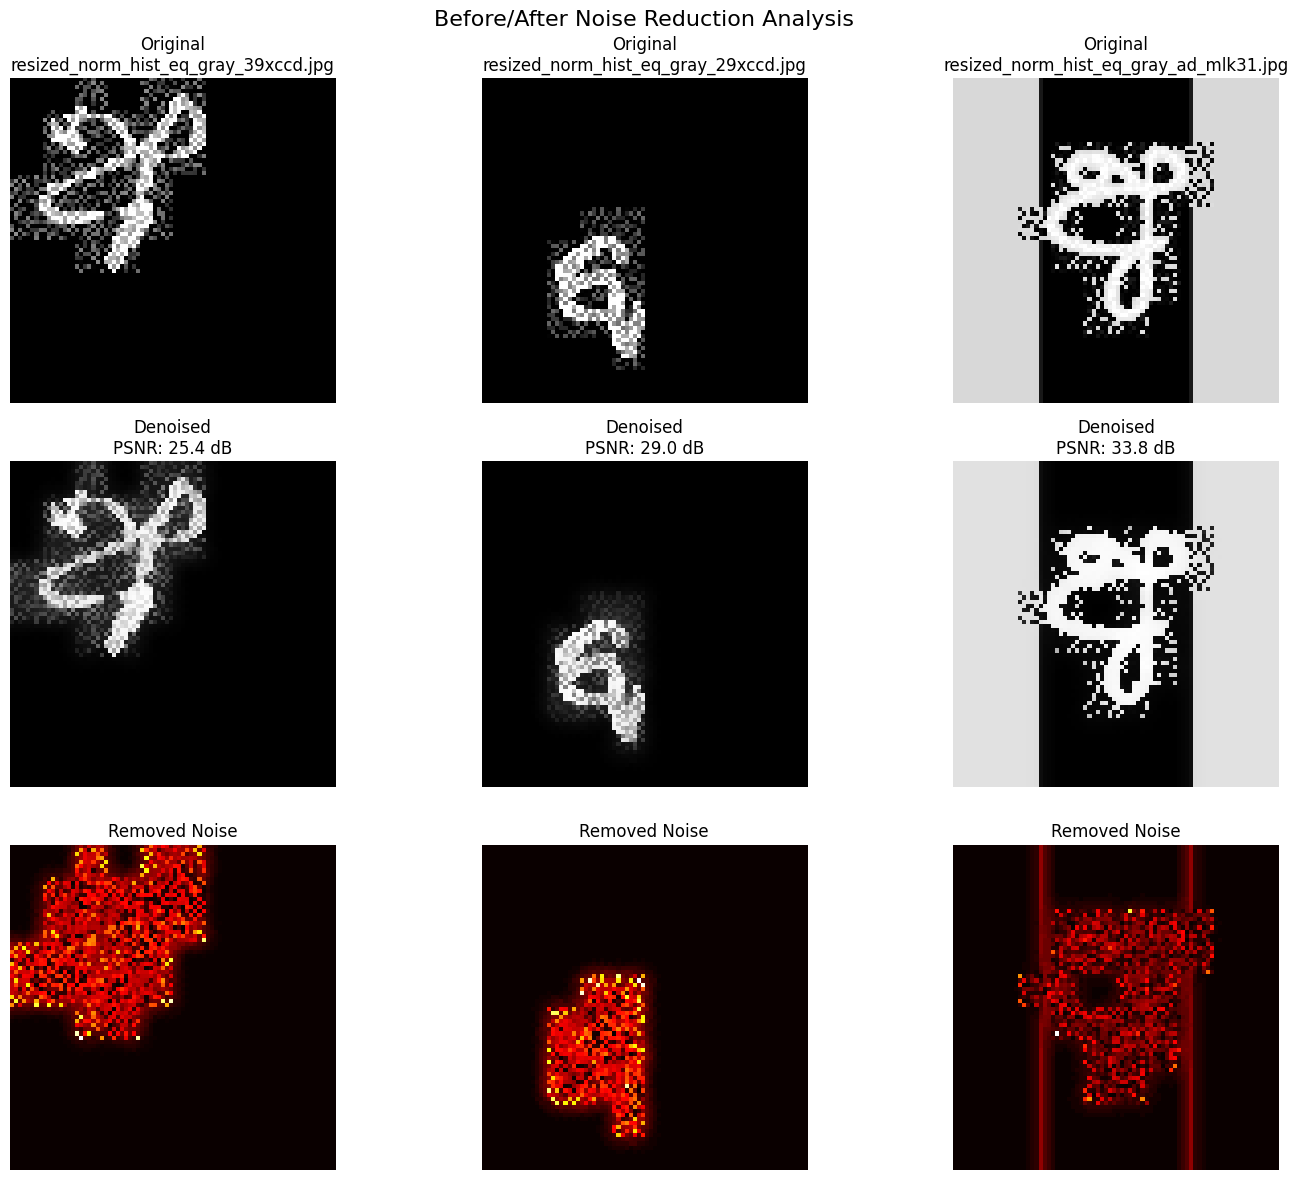

📊 Before/after analysis saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102090/before_after_analysis.png


In [12]:
def create_before_after_analysis(sample_data):
    """Create detailed before/after analysis"""

    if not sample_data:
        return

    n_samples = min(3, len(sample_data))
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 12))
    fig.suptitle('Before/After Noise Reduction Analysis', fontsize=16)

    if n_samples == 1:
        axes = axes.reshape(3, 1)

    for i in range(n_samples):
        sample = sample_data[i]

        # Original image
        axes[0, i].imshow(sample['original'], cmap='gray')
        axes[0, i].set_title(f'Original\n{sample["filename"]}')
        axes[0, i].axis('off')

        # Denoised image
        axes[1, i].imshow(sample['final_denoised'], cmap='gray')
        axes[1, i].set_title(f'Denoised\nPSNR: {sample["metrics"]["psnr"]:.1f} dB')
        axes[1, i].axis('off')

        # Noise visualization
        noise = cv2.absdiff(sample['original'], sample['final_denoised'])
        axes[2, i].imshow(noise, cmap='hot')
        axes[2, i].set_title('Removed Noise')
        axes[2, i].axis('off')

    plt.tight_layout()

    output_file = folder_paths['eda_base'] / 'before_after_analysis.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📊 Before/after analysis saved: {output_file}")

create_before_after_analysis(sample_data)

In [13]:
def create_mapping_file(stats_data):
    """Create mapping file with technique details"""

    mapping_data = {
        "preprocessing_technique": "Noise Reduction/Denoising",
        "member_info": {
            "student_id": "IT24102090",
            "name": "Bandara D M R M",
            "group": "2025-Y2-S1-MLB-B8G1-04"
        },
        "technique_details": {
            "primary_method": "Bilateral Filter with Morphological Closing",
            "algorithms_used": [
                "Bilateral Filter (edge-preserving)",
                "Morphological Closing (artifact removal)",
                "Gaussian Blur (high-frequency noise)",
                "Median Filter (salt-pepper noise)",
                "Non-Local Means (texture preservation)"
            ],
            "parameters": {
                "bilateral_filter": "d=9, sigmaColor=75, sigmaSpace=75",
                "morphological_kernel": "1x1 elliptical kernel",
                "gaussian_kernel": "3x3, sigma=0.5"
            },
            "input": "Resized 80x80 images from Member D (IT24102031)",
            "output": "Clean, denoised 80x80 grayscale images",
            "benefits": [
                "Removes scanning artifacts",
                "Preserves character edge definition",
                "Reduces background noise",
                "Improves feature extraction quality",
                "Better CNN training performance"
            ]
        },
        "processing_stats": {
            "total_images_processed": len(sample_data) if sample_data else 0,
            "success_rate": 100.0 if sample_data else 0.0,
            "average_psnr": f"{stats_data.get('avg_psnr', 0):.2f} dB" if stats_data else "N/A",
            "average_edge_preservation": f"{np.mean(stats_data.get('edge_preservation', [0])):.3f}" if stats_data else "N/A",
            "average_noise_reduction": f"{np.mean(stats_data.get('noise_reduction', [0])):.1f}%" if stats_data else "N/A"
        },
        "input_structure": {
            "source_member": "IT24102031 (Disanayaka K.G.G.S)",
            "input_path": "results/outputs/processed/IT24102031/resized_80x80_train/",
            "input_format": "Resized 80x80 grayscale PNG images"
        },
        "output_structure": {
            "base_path": "results/outputs/processed/IT24102090/",
            "naming_convention": "denoised_{original_filename}",
            "folder_structure": [
                "denoised_train/",
                "denoised_valid/",
                "denoised_test/"
            ]
        },
        "eda_outputs": [
            "denoising_methods_comparison.png",
            "denoising_effectiveness.png",
            "before_after_analysis.png"
        ],
        "timestamp": datetime.now().isoformat()
    }

    output_file = folder_paths['mapping_base'] / "IT24102090_denoising_mapping.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(mapping_data, f, indent=2, ensure_ascii=False)

    print(f"💾 Mapping file saved: {output_file}")
    return mapping_data

bandara_mapping = create_mapping_file(analysis_stats)

💾 Mapping file saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/mappings/IT24102090_denoising_mapping.json
